In [ ]:
# Connecing Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Installing importing patool to Extract rar file
!pip install patool
import patoolib
dataset_path = '/content/drive/MyDrive/Human_Activity_Recognition/'
Model_save_path = '/content/drive/MyDrive/Human_Activity_Recognition/Models/'
patoolib.extract_archive(dataset_path + "Data.rar", outdir="/content")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 3.0 MB/s eta 0:00:00
patool: Extracting /content/drive/MyDrive/Human_Activity_Recognition/Data.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/Human_Activity_Recognition/Data.rar
patool:     with cwd='/content'
patool: ... /content/drive/MyDrive/Human_Activity_Recognition/Data.rar extracted to `/content'.


'/content'

In [ ]:
## Importing required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
import cv2
import os

In [ ]:
# Print all the labels
labels = os.listdir("/content/Data")
print(labels)

['ThrowDiscus', 'HorseRiding', 'Bowling', 'CricketShot', 'HammerThrow', 'Biking', 'PizzaTossing', 'Typing', 'Knitting', 'Haircut', 'Hammering', 'JavelinThrow', 'PlayingFlute', 'Billiards', 'SoccerJuggling', 'TableTennisShot', 'JugglingBalls', 'CuttingInKitchen', 'Rafting', 'Drumming']


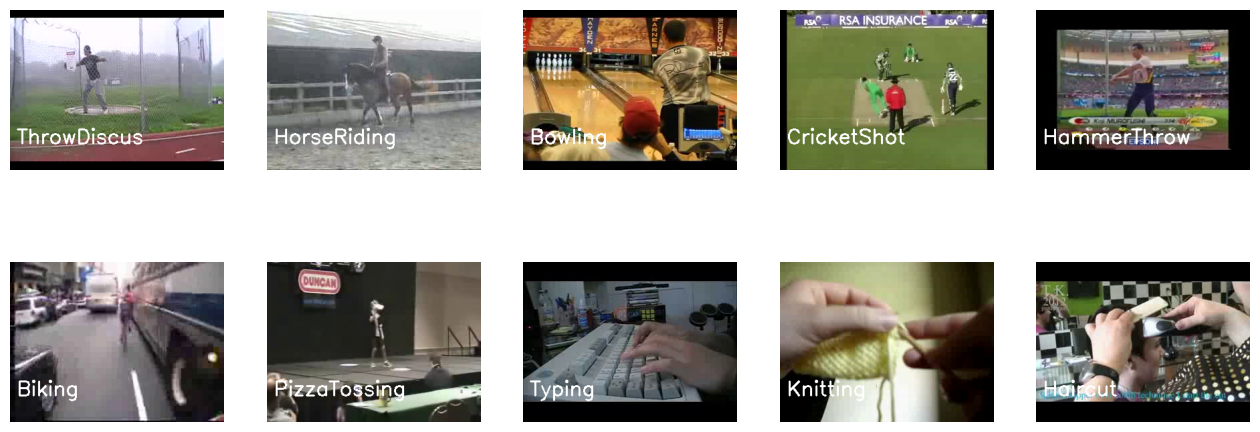

In [ ]:
# Plotting sample video frames
plt.figure(figsize=(16,6))
for i in np.arange(10):
  plt.subplot(2,5,i+1)
  video_path = os.path.join("/content/Data/", labels[i] , os.listdir(os.path.join("/content/Data/", labels[i]))[5])
  reader = cv2.VideoCapture(video_path)
  _ , frames = reader.read()
  frame = cv2.cvtColor(frames ,cv2.COLOR_BGR2RGB)
  cv2.putText(frame, labels[i], (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,)
  plt.imshow(frame)
  plt.axis("off")
reader.release()
plt.show()

In [ ]:
# Importing tensorflow libraries
from tensorflow.keras.utils import to_categorical , plot_model , set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , MaxPooling2D , Dropout , TimeDistributed , Conv2D , Dense , Flatten
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv3D , MaxPooling3D
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

set_random_seed(110)

In [ ]:
# Converting Image into 224 * 224 for VGG16 , Resnet50 and MobileNetV3 model
# Taking 10 Classes and 5 frame per video
frames_required = 5
X_ = []
y_ = []
classes =[]
for i in np.arange(10):
  class_name = os.listdir("/content/Data")[i]
  class_path = os.path.join("/content/Data", os.listdir("/content/Data")[i])
  classes.append(class_name)
  for j in np.arange(len(os.listdir(class_path))): # Going inside the Folder for each file
    video_path =  os.path.join(class_path , os.listdir(class_path)[j])
    reader = cv2.VideoCapture(video_path)
    total_frames = reader.get(cv2.CAP_PROP_FRAME_COUNT)
    skip_window = int(total_frames / frames_required)
    frames = []
    for k in np.arange(frames_required):
      reader.set(cv2.CAP_PROP_POS_FRAMES,(k*skip_window))
      _, frame =  reader.read()
      frame_resize = cv2.resize(frame , (224, 224))
      frame_normalized =  (frame_resize)/255.0
      frames.append(frame_normalized)
    X_.append(frames)
    y_.append(i)
    reader.release()
  print("Data Extracted" , class_name)

Data Extracted ThrowDiscus
Data Extracted HorseRiding
Data Extracted Bowling
Data Extracted CricketShot
Data Extracted HammerThrow
Data Extracted Biking
Data Extracted PizzaTossing
Data Extracted Typing
Data Extracted Knitting
Data Extracted Haircut


In [ ]:
## Train Test Split
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y_ =  np.array(y_)
y_ =  to_categorical(y_)
X_ =  np.array(X_)
y_ = np.array(y_)
X_train, X_test , y_train, y_test =  train_test_split(X_,y_, random_state = 123 , shuffle = True , test_size = 0.20)
del  X_, y_
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1121, 5, 224, 224, 3)
(281, 5, 224, 224, 3)
(1121, 10)
(281, 10)


## VGG19

In [ ]:
base_model =  VGG19(include_top = False, input_shape = (224,224,3), weights = 'imagenet')
for layer in base_model.layers:
  layer.trainable = False

vgg_model = Sequential()
vgg_model.add(TimeDistributed(base_model,input_shape = (5,224,224,3)))
vgg_model.add(TimeDistributed(Flatten()))
vgg_model.add(LSTM(32))
vgg_model.add(Dense(10, activation = "softmax"))
vgg_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 5, 7, 7, 512)      20024384  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 25088)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 32)                3215488   
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 23240202 (88.65 MB)
Trainable params: 3215818 (12.27 MB)
Non-trainable params: 20024384 (76.39 MB)
__________

In [ ]:
vgg_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_checkpoint = ModelCheckpoint(filepath= Model_save_path + 'Vgg19.h5' , monitor = 'val_loss', save_best_only = True , verbose = 1)
history = vgg_model.fit(x = X_train, y = y_train, epochs = 40, batch_size = 16, shuffle = False, validation_split=0.2, callbacks = [model_checkpoint])

Epoch 1/40
56/56 [==============================] - ETA: 0s - loss: 2.2348 - accuracy: 0.2511
Epoch 1: val_loss improved from inf to 2.05933, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/Vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 47s 507ms/step - loss: 2.2348 - accuracy: 0.2511 - val_loss: 2.0593 - val_accuracy: 0.3511
Epoch 2/40
56/56 [==============================] - ETA: 0s - loss: 1.8735 - accuracy: 0.4877
Epoch 2: val_loss improved from 2.05933 to 1.82081, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/Vgg19.h5
56/56 [==============================] - 26s 461ms/step - loss: 1.8735 - accuracy: 0.4877 - val_loss: 1.8208 - val_accuracy: 0.5156
Epoch 3/40
56/56 [==============================] - ETA: 0s - loss: 1.6786 - accuracy: 0.6964
Epoch 3: val_loss improved from 1.82081 to 1.67083, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/Vgg19.h5
56/56 [==============================] - 27s 477ms/step - loss: 1.6786 - accuracy: 0.6964 - val_loss: 1.6708 - val_accuracy: 0.7467
Epoch 4/40
56/56 [==============================] - ETA: 0s - loss: 1.5597 - accuracy: 0.8516
Epoch 4: val_loss improved from 1.67083 to 1.59017, sa

In [ ]:
VGG_19_loss,VGG_19_accuracy = vgg_model.evaluate(X_test, y_test)
print("Loss on test Set {} , Accuracy on Test set {} .format", VGG_19_loss , VGG_19_accuracy)

9/9 [==============================] - 42s 3s/step - loss: 0.3394 - accuracy: 0.9253
Loss on test Set {} , Accuracy on Test set {} .format 0.33940640091896057 0.9252669215202332


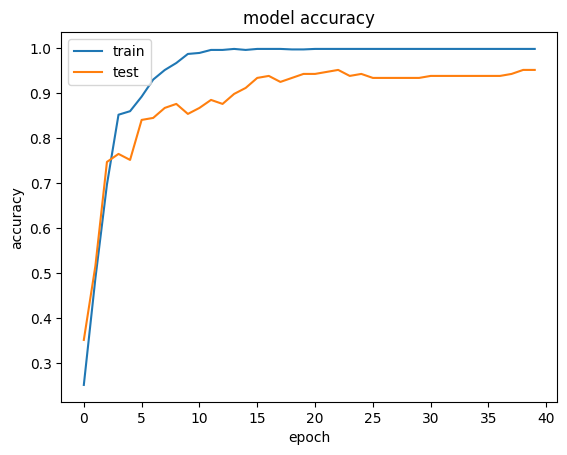

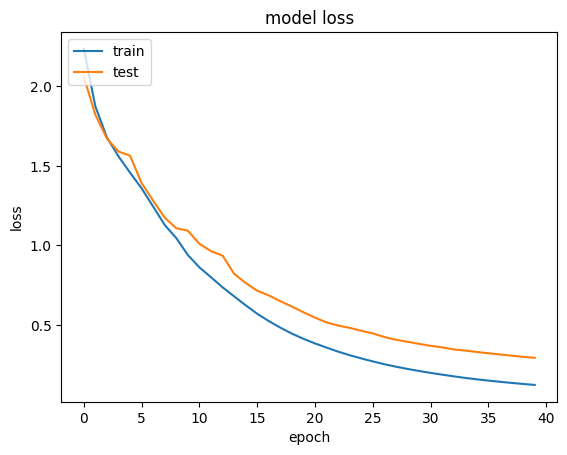

In [ ]:
## Plotting Accuracy and loss data
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Xception

In [ ]:
# Loading the Xception model with pre-trained weights on imagenet
from tensorflow.keras.applications.xception import Xception

base_model =  Xception(include_top = False, input_shape = (224,224,3), weights = 'imagenet')
for layer in base_model.layers:
  layer.trainable = False

Xception_model = Sequential()
Xception_model.add(TimeDistributed(base_model,input_shape = (5,224,224,3)))
Xception_model.add(TimeDistributed(Flatten()))
Xception_model.add(LSTM(32))
Xception_model.add(Dense(10, activation = "softmax"))
Xception_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeD  (None, 5, 7, 7, 2048)     20861480  
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 5, 100352)         0         
 istributed)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12849280  
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 33711090 (128.60 MB)
Trainable params: 12849610 (49.02 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [ ]:
Xception_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_checkpoint = ModelCheckpoint(filepath= Model_save_path + 'Xception.h5' , monitor = 'val_loss', save_best_only = True, verbose = 1)
history = Xception_model.fit(x = X_train, y = y_train, epochs = 30, batch_size = 16, shuffle = False, validation_split=0.2, callbacks = [model_checkpoint])

Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.6954 - accuracy: 0.4888
Epoch 1: val_loss improved from inf to 1.37129, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/Xception.h5
56/56 [==============================] - 31s 476ms/step - loss: 1.6954 - accuracy: 0.4888 - val_loss: 1.3713 - val_accuracy: 0.6356
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.2428 - accuracy: 0.6920
Epoch 2: val_loss improved from 1.37129 to 1.13820, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/Xception.h5
56/56 [==============================] - 26s 460ms/step - loss: 1.2428 - accuracy: 0.6920 - val_loss: 1.1382 - val_accuracy: 0.7333
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.9241 - accuracy: 0.8058
Epoch 3: val_loss improved from 1.13820 to 0.88239, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/Xception.h5
56/56 [==============================] - 25s 44

In [ ]:
from tensorflow.keras.models import load_model
Xception_model = load_model(Model_save_path + "Xception.h5")
Xception_model_loss,Xception_model_accuracy = Xception_model.evaluate(X_test, y_test)
print("Loss on test Set {} , Accuracy on Test set {} .format", Xception_model_loss , Xception_model_accuracy)

9/9 [==============================] - 20s 1s/step - loss: 0.1396 - accuracy: 0.9537
Loss on test Set {} , Accuracy on Test set {} .format 0.13961422443389893 0.9537366628646851


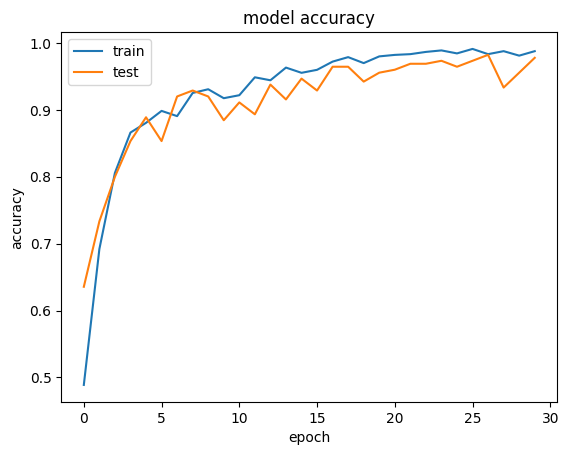

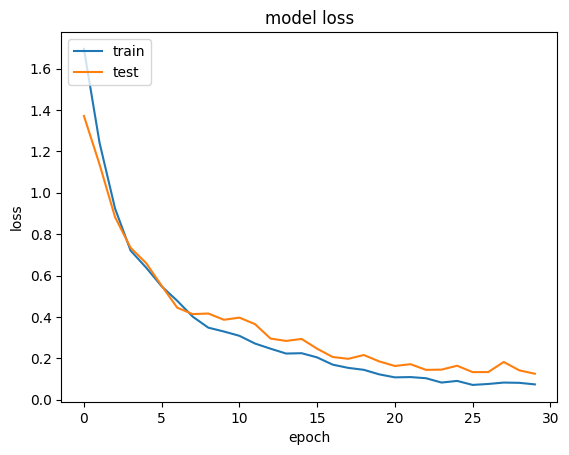

In [ ]:
## Plotting Accuracy and loss data
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## MobileNetV2

In [ ]:
base_model =  MobileNetV2(include_top = False, input_shape = (224,224,3), weights = 'imagenet')
for layer in base_model.layers:
  layer.trainable = False

mobilenet_model = Sequential()
mobilenet_model.add(TimeDistributed(base_model,input_shape = (5,224,224,3)))
mobilenet_model.add(TimeDistributed(Flatten()))
mobilenet_model.add(LSTM(32))
mobilenet_model.add(Dense(10, activation = "softmax"))
mobilenet_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 5, 7, 7, 1280)     2257984   
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 5, 62720)          0         
 stributed)                                                      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8032384   
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 10290698 (39.26 MB)
Trainable params: 8032714 (30.64 MB)
Non-trainable params: 2257984 (8.61 MB)
____________

In [ ]:
mobilenet_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_checkpoint = ModelCheckpoint(filepath= Model_save_path + 'mobilenet_v2.h5' , monitor = 'val_loss', save_best_only = True,verbose = 1)
history = mobilenet_model.fit(x = X_train, y = y_train, epochs = 40, batch_size = 16, shuffle = False, validation_split=0.2, callbacks = [model_checkpoint])

Epoch 1/40
56/56 [==============================] - ETA: 0s - loss: 2.0549 - accuracy: 0.3225
Epoch 1: val_loss improved from inf to 1.85023, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/mobilenet_v2.h5
56/56 [==============================] - 15s 190ms/step - loss: 2.0549 - accuracy: 0.3225 - val_loss: 1.8502 - val_accuracy: 0.4133
Epoch 2/40
56/56 [==============================] - ETA: 0s - loss: 1.6849 - accuracy: 0.5022
Epoch 2: val_loss improved from 1.85023 to 1.48875, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/mobilenet_v2.h5
56/56 [==============================] - 8s 143ms/step - loss: 1.6849 - accuracy: 0.5022 - val_loss: 1.4887 - val_accuracy: 0.6400
Epoch 3/40
56/56 [==============================] - ETA: 0s - loss: 1.3507 - accuracy: 0.7556
Epoch 3: val_loss improved from 1.48875 to 1.32822, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/mobilenet_v2.h5
56/56 [=============================

In [ ]:
mobilenet_loss,mobilenet_accuracy = mobilenet_model.evaluate(X_test, y_test)
print("Loss on test Set {} , Accuracy on Test set {}".format, mobilenet_loss , mobilenet_accuracy)

9/9 [==============================] - 2s 195ms/step - loss: 0.1519 - accuracy: 0.9609
<built-in method format of str object at 0x7ad5645efbd0> 0.15190884470939636 0.9608541131019592


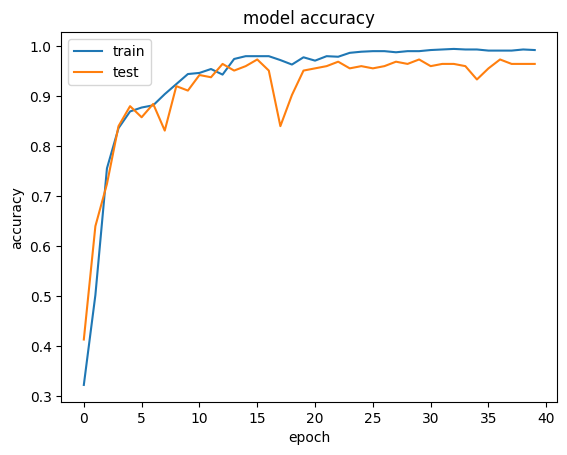

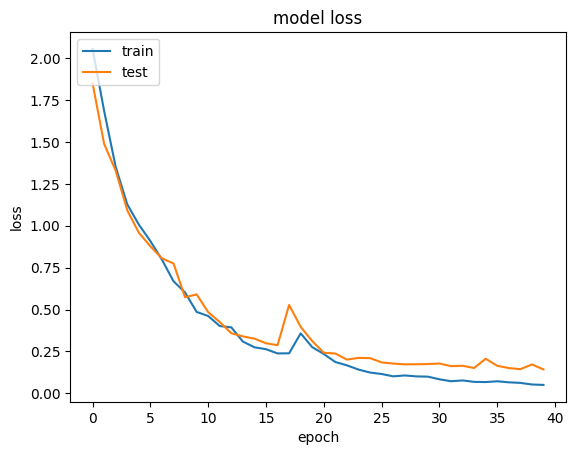

In [ ]:
## Plotting Accuracy and loss data
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import pickle as pkl
with open(dataset_path + "Classes_1.pkl", 'wb') as handle:
    pkl.dump(classes, handle)

In [ ]:
del X_train , X_test , y_train , y_test

In [ ]:
# Getting all the frames with their respective class
## For Image Size  64 * 64 . ForConv+LSTM model and Conv3D model
classes_ =[]
frames_required = 20
img_height = 64
img_width = 64

X = []
y = []

for i in np.arange(len(os.listdir("/content/Data"))):
  class_name = os.listdir("/content/Data")[i]
  class_path = os.path.join("/content/Data", os.listdir("/content/Data")[i])
  classes_.append(class_name)
  for j in np.arange(len(os.listdir(class_path))): # Going inside the Folder for each file
    video_path =  os.path.join(class_path , os.listdir(class_path)[j])
    reader = cv2.VideoCapture(video_path)
    total_frames = reader.get(cv2.CAP_PROP_FRAME_COUNT)
    skip_window = int(total_frames / frames_required)
    frames = []
    for k in np.arange(frames_required):
      reader.set(cv2.CAP_PROP_POS_FRAMES,(k*skip_window))
      _, frame =  reader.read()
      frame_resize = cv2.resize(frame , (img_height, img_width))
      frame_normalized =  (frame_resize)/255.0
      frames.append(frame_normalized)
    X.append(frames)
    y.append(i)
    reader.release()
  print("Preprocessing done : " , class_name)

Preprocessing done :  ThrowDiscus
Preprocessing done :  HorseRiding
Preprocessing done :  Bowling
Preprocessing done :  CricketShot
Preprocessing done :  HammerThrow
Preprocessing done :  Biking
Preprocessing done :  PizzaTossing
Preprocessing done :  Typing
Preprocessing done :  Knitting
Preprocessing done :  Haircut
Preprocessing done :  Hammering
Preprocessing done :  JavelinThrow
Preprocessing done :  PlayingFlute
Preprocessing done :  Billiards
Preprocessing done :  SoccerJuggling
Preprocessing done :  TableTennisShot
Preprocessing done :  JugglingBalls
Preprocessing done :  CuttingInKitchen
Preprocessing done :  Rafting
Preprocessing done :  Drumming


In [ ]:
# Print the Shape of X and y
from sklearn.model_selection import train_test_split
y =  to_categorical(y)
X =  np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

## Train Test Split
X_train, X_test , y_train, y_test =  train_test_split(X,y, random_state = 123 , shuffle = True , test_size = 0.20)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
del X,y

(2754, 20, 64, 64, 3)
(2754, 20)
(2203, 20, 64, 64, 3)
(551, 20, 64, 64, 3)
(2203, 20)
(551, 20)


## CNN +  LSTM

In [ ]:
## Model Defining
model = Sequential()
model.add(TimeDistributed(Conv2D(filters = 16, kernel_size =(3,3),strides = (1,1),padding = "same", activation = 'relu'),
                          input_shape = (frames_required,img_height,img_width,3)))
model.add(TimeDistributed(MaxPooling2D(pool_size =(2,2))))
model.add(TimeDistributed(Dropout(rate=0.25)))

model.add(TimeDistributed(Conv2D(filters = 32, kernel_size =(3,3),strides = (1,1),padding = "same", activation = 'relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size =(2,2))))
model.add(TimeDistributed(Dropout(rate=0.25)))

model.add(TimeDistributed(Conv2D(filters = 64, kernel_size =(3,3),strides = (1,1),padding = "same", activation = 'relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size =(2,2))))
model.add(TimeDistributed(Dropout(rate=0.25)))

model.add(TimeDistributed(Conv2D(filters = 128, kernel_size =(3,3),strides = (1,1),padding = "same", activation = 'relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size =(2,2))))
model.add(TimeDistributed(Dropout(rate=0.25)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dense(20, activation = "softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 20, 32, 32, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 20, 32, 32, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 20, 32, 32, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 20, 16, 16, 32)   

In [ ]:
# Model Compiling and Training
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_checkpoint = ModelCheckpoint(filepath= Model_save_path + 'CNN_LSTM.h5' , monitor = 'val_loss', save_best_only = True, verbose = 1)
history = model.fit(x = X_train, y = y_train, epochs = 40, batch_size = 32, shuffle = True, validation_split=0.2, callbacks = [model_checkpoint])

Epoch 1/40
56/56 [==============================] - ETA: 0s - loss: 2.9703 - accuracy: 0.0880
Epoch 1: val_loss improved from inf to 2.88622, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/CNN_LSTM.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 20s 107ms/step - loss: 2.9703 - accuracy: 0.0880 - val_loss: 2.8862 - val_accuracy: 0.1361
Epoch 2/40
55/56 [============================>.] - ETA: 0s - loss: 2.6116 - accuracy: 0.2062
Epoch 2: val_loss improved from 2.88622 to 2.61567, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/CNN_LSTM.h5
56/56 [==============================] - 4s 67ms/step - loss: 2.6109 - accuracy: 0.2066 - val_loss: 2.6157 - val_accuracy: 0.1814
Epoch 3/40
55/56 [============================>.] - ETA: 0s - loss: 2.2957 - accuracy: 0.2716
Epoch 3: val_loss improved from 2.61567 to 2.24271, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/CNN_LSTM.h5
56/56 [==============================] - 4s 66ms/step - loss: 2.2950 - accuracy: 0.2719 - val_loss: 2.2427 - val_accuracy: 0.3356
Epoch 4/40
55/56 [============================>.] - ETA: 0s - loss: 2.0234 - accuracy: 0.3722
Epoch 4: val_loss improved from 2.24271 to 1.96799, 

In [ ]:
CNN_loss,CNN_accuracy = model.evaluate(X_test, y_test)
print("Loss on test Set {} , Accuracy on Test set {} ".format( CNN_loss , CNN_accuracy))

18/18 [==============================] - 0s 26ms/step - loss: 0.3994 - accuracy: 0.8893
Loss on test Set 0.39941921830177307 , Accuracy on Test set 0.8892921805381775 


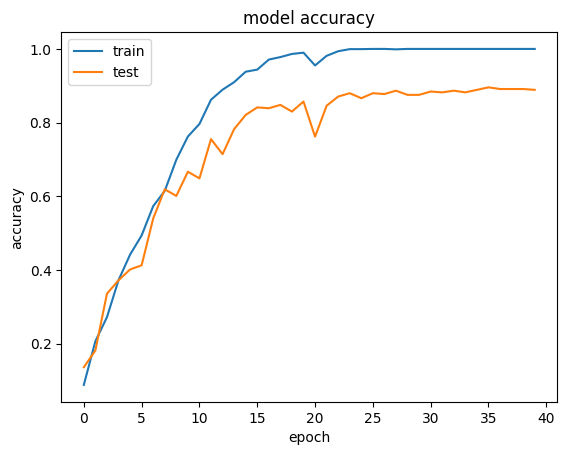

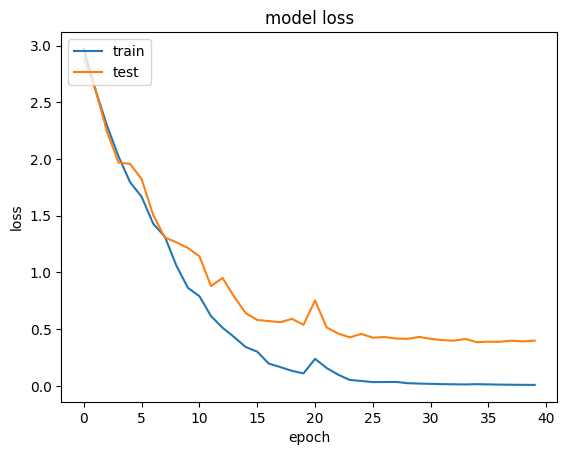

In [ ]:
## Plotting Accuracy and loss data
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3D Convolutional Network


In [ ]:
model = Sequential()

model.add(Conv3D(filters=64, kernel_size =(3,3,3), strides = (1,1,1),padding ="same", activation ='relu', input_shape = (20,64,64,3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.20))

model.add(Conv3D(filters=128, kernel_size =(3,3,3), strides = (1,1,1),padding ="same", activation ='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.20))


model.add(Conv3D(filters=256, kernel_size =(3,3,3), strides = (1,1,1),padding ="same", activation ='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 64, 64, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 32, 32, 64)    0         
 D)                                                              
                                                                 
 dropout_8 (Dropout)         (None, 10, 32, 32, 64)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 5, 16, 16, 128)    0         
 g3D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 5, 16, 16, 128)   

In [ ]:
# Model Compiling and Training
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_checkpoint = ModelCheckpoint(filepath= Model_save_path + 'Con3D.h5' , monitor = 'val_loss', save_best_only = True, verbose = 1)
history = model.fit(x = X_train, y = y_train, epochs = 40, batch_size = 32, shuffle = True, validation_split=0.2, callbacks =[model_checkpoint])

Epoch 1/40
56/56 [==============================] - ETA: 0s - loss: 3.3211 - accuracy: 0.1118
Epoch 1: val_loss improved from inf to 2.60777, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/Con3D.h5
56/56 [==============================] - 24s 354ms/step - loss: 3.3211 - accuracy: 0.1118 - val_loss: 2.6078 - val_accuracy: 0.2086
Epoch 2/40
55/56 [============================>.] - ETA: 0s - loss: 2.3878 - accuracy: 0.2727
Epoch 2: val_loss improved from 2.60777 to 2.09595, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/Con3D.h5
56/56 [==============================] - 20s 360ms/step - loss: 2.3870 - accuracy: 0.2730 - val_loss: 2.0960 - val_accuracy: 0.3605
Epoch 3/40
55/56 [============================>.] - ETA: 0s - loss: 1.9326 - accuracy: 0.4187
Epoch 3: val_loss improved from 2.09595 to 1.64788, saving model to /content/drive/MyDrive/Human_Activity_Recognition/Models/Con3D.h5
56/56 [==============================] - 20s 356ms/step 

In [ ]:
CNN_3D_loss,CNN_3D_accuracy = model.evaluate(X_test, y_test)
print("Loss on test Set {} , Accuracy on Test set {} .format", CNN_3D_loss , CNN_3D_accuracy)

18/18 [==============================] - 2s 124ms/step - loss: 1.2323 - accuracy: 0.8276
Loss on test Set {} , Accuracy on Test set {} .format 1.232265830039978 0.8275862336158752


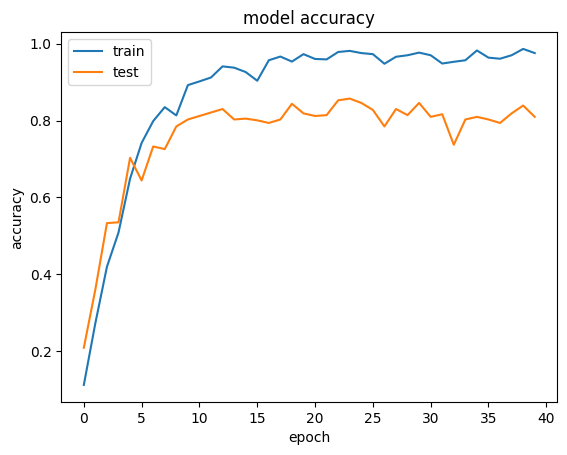

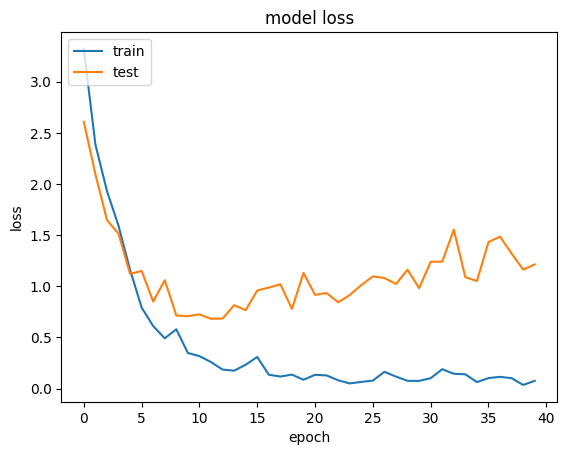

In [ ]:
## Plotting Accuracy and loss data
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import pickle as pkl
with open(dataset_path + "Classes_2.pkl", 'wb') as handle:
    pkl.dump(classes_, handle)

In [ ]:
VGG_19_accuracy = 0.9252669215202332
Xception_model_accuracy = 0.9537366628646851
mobilenet_accuracy = 0.9608541131019592
CNN_accuracy = 0.8892921805381775
CNN_3D_accuracy = 0.8275862336158752

pd.DataFrame(index = ["VGG_19 + LSTM","Xception + LSTM", "mobilenet + LSTM", "CNN + LSTM", "CNN_3D"],
             data = [VGG_19_accuracy,Xception_model_accuracy, mobilenet_accuracy, CNN_accuracy, CNN_3D_accuracy],
             columns = ["Test_Set_Accuracy"])

,Test_Set_Accuracy
VGG_19 + LSTM,0.925267
Xception + LSTM,0.953737
mobilenet + LSTM,0.960854
CNN + LSTM,0.889292
CNN_3D,0.827586
